## Tutorial

Welcome to `ktplotspy`! This is a python library to help visualise `CellphoneDB` results, ported from the original [ktplots R package](https://www.github.com/zktuong/ktplots) (which still has several other visualisation options). Here, we will go through a quick tutorial on how to use the functions in this package.

**Import libraries**

In [1]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt

In [2]:
# the data is in the github folder if you clone the repo
os.chdir(os.path.expanduser("~/Documents/Github/ktplotspy"))

# read in the files
# 1) .h5ad file used for performing cellphonedb
adata = ad.read_h5ad("data/kidneyimmune.h5ad")

# 2) output from cellphonedb
means = pd.read_csv("/Users/Ali/Desktop/Cellophane/v5_means.txt", sep="\t")
pvals = pd.read_csv("/Users/Ali/Desktop/Cellophane/v5_pvalues.txt", sep="\t")
interaction_scores = pd.read_csv("/Users/Ali/Desktop/Cellophane/v5_interaction_scores.txt", sep="\t")

In [3]:
import numpy as np
import pandas as pd
import re

from plotnine import (
    aes,
    element_blank,
    element_rect,
    element_text,
    geom_point,
    ggplot,
    ggtitle,
    guide_colourbar,
    guide_legend,
    guides,
    options,
    scale_colour_continuous,
    scale_colour_manual,
    scale_fill_continuous,
    scale_fill_manual,
    scale_size_continuous,
    theme,
    theme_bw,
)
from typing import List, Literal, Optional, Union, Tuple, Dict

from ktplotspy.utils.settings import DEFAULT_SEP, DEFAULT_SPEC_PAT
from ktplotspy.utils.support import (
    ensure_categorical,
    filter_interaction_and_celltype,
    hclust,
    prep_celltype_query,
    prep_query_group,
    prep_table,
    set_x_stroke,
    sub_pattern,
)

In [4]:
# adata: "AnnData" =
cell_type1 = "B cell"
cell_type2 = "."
celltype_key = "celltype"
default_style = True
interaction_scores: Optional[pd.DataFrame] = interaction_scores
degs_analysis: bool = False
splitby_key: Optional[str] = None
alpha: float = 0.05
keep_significant_only: bool = True
genes: Optional[str] = None
gene_family: Optional[Literal["chemokines", "th1", "th2", "th17", "treg", "costimulatory", "coinhibitory"]] = None
custom_gene_family: Optional[Dict[str, List[str]]] = None
standard_scale: bool = True
cluster_rows: bool = True
cmap_name: str = "viridis"
max_size: int = 8
max_highlight_size: int = 3
default_style: bool = True
highlight_col: str = "#d62728"
highlight_size: Optional[int] = None
special_character_regex_pattern: Optional[str] = None
exclude_interactions: Optional[Union[List, str]] = None
title: str = ""
return_table: bool = False
figsize: Tuple[Union[int, float], Union[int, float]] = (6.4, 4.8)

In [5]:
if special_character_regex_pattern is None:
    special_character_regex_pattern = DEFAULT_SPEC_PAT
swapr = True if (cell_type1 == ".") or (cell_type2 == ".") else False
# prepare data
metadata = adata.obs.copy()
means_mat = prep_table(data=means)
pvals_mat = prep_table(data=pvals)
if interaction_scores is not None:
    interaction_scores_mat = prep_table(data=interaction_scores)
if degs_analysis:
    col_start = 13 if pvals_mat.columns[12] == "classification" else 11  # in v5, there are 12 columns before the values
    pvals_mat.iloc[:, col_start : pvals_mat.shape[1]] = 1 - pvals_mat.iloc[:, col_start : pvals_mat.shape[1]]
# ensure celltypes are ok
cell_type1 = sub_pattern(cell_type=cell_type1, pattern=special_character_regex_pattern)
cell_type2 = sub_pattern(cell_type=cell_type2, pattern=special_character_regex_pattern)
# check for query
if genes is None:
    if gene_family is not None:
        query_group = prep_query_group(means_mat, custom_gene_family)
        if isinstance(gene_family, list):
            query = []
            for gf in gene_family:
                if gf.lower() in query_group:
                    for gfg in query_group[gf.lower()]:
                        query.append(gfg)
                else:
                    raise KeyError("gene_family needs to be one of the following: {}".format(query_group.keys()))
            query = list(set(query))
        else:
            if gene_family.lower() in query_group:
                query = query_group[gene_family.lower()]
            else:
                raise KeyError("gene_family needs to be one of the following: {}".format(query_group.keys()))
    else:
        query = [i for i in means_mat.interacting_pair if re.search("", i)]
elif genes is not None:
    if gene_family is not None:
        raise KeyError("Please specify either genes or gene_family, not both.")
    else:
        query = [i for i in means_mat.interacting_pair if re.search("|".join(genes), i)]
metadata = ensure_categorical(meta=metadata, key=celltype_key)

In [6]:
if splitby_key is not None:
    metadata = ensure_categorical(meta=metadata, key=splitby_key)
    groups = list(metadata[splitby_key].cat.categories)
    metadata["_labels"] = [s + "_" + c for s, c in zip(metadata[splitby_key], metadata[celltype_key])]
    metadata["_labels"] = metadata["_labels"].astype("category")
    cat_orders = []
    for s in metadata[splitby_key].cat.categories:
        for c in metadata[celltype_key].cat.categories:
            cat_orders.append(s + "_" + c)
    cat_orders = [x for x in cat_orders if x in list(metadata._labels)]
    metadata["_labels"] = metadata["_labels"].cat.reorder_categories(cat_orders)
    celltype = prep_celltype_query(
        meta=metadata,
        cell_type1=cell_type1,
        cell_type2=cell_type2,
        pattern=special_character_regex_pattern,
        split_by=splitby_key,
    )
else:
    metadata["_labels"] = metadata[celltype_key]
    celltype = prep_celltype_query(
        meta=metadata,
        cell_type1=cell_type1,
        cell_type2=cell_type2,
        pattern=special_character_regex_pattern,
        split_by=splitby_key,
    )
cell_type = "|".join(celltype)
# keep cell types
if swapr:
    ct_columns = [ct for ct in means_mat.columns if re.search(ct, cell_type)]
else:
    ct_columns = [ct for ct in means_mat.columns if re.search(cell_type, ct)]

    
# filter
means_matx = filter_interaction_and_celltype(data=means_mat, genes=query, celltype_pairs=ct_columns)
pvals_matx = filter_interaction_and_celltype(data=pvals_mat, genes=query, celltype_pairs=ct_columns)
if interaction_scores is not None:
    interaction_scores_matx = filter_interaction_and_celltype(data=interaction_scores_mat, genes=query, celltype_pairs=ct_columns)
# reorder the columns
col_order = []
if splitby_key is not None:
    for g in groups:
        for c in means_matx.columns:
            if re.search(g, c):
                col_order.append(c)
else:
    col_order = means_matx.columns
means_matx = means_matx[col_order]
pvals_matx = pvals_matx[col_order]
if interaction_scores is not None:
    interaction_scores_matx = interaction_scores_matx[col_order]
# whether or not to filter to only significant hits
if keep_significant_only:
    keep_rows = pvals_matx.apply(lambda r: any(r < alpha), axis=1)
    keep_rows = [r for r, k in keep_rows.items() if k]
    if len(keep_rows) > 0:
        pvals_matx = pvals_matx.loc[keep_rows]
        means_matx = means_matx.loc[keep_rows]
        if interaction_scores is not None:
            interaction_scores_matx = interaction_scores_matx.loc[keep_rows]
# run hierarchical clustering on the rows based on interaction value.
if cluster_rows:
    if means_matx.shape[0] > 2:
        h_order = hclust(means_matx, axis=0)
        means_matx = means_matx.loc[h_order]
        pvals_matx = pvals_matx.loc[h_order]
        if interaction_scores is not None:
            interaction_scores_matx = interaction_scores_matx.loc[h_order]
if standard_scale:
    means_matx = means_matx.apply(lambda r: (r - np.min(r)) / (np.max(r) - np.min(r)), axis=1)
means_matx.fillna(0, inplace=True)
# prepare final table
colm = "scaled_means" if standard_scale else "means"

In [7]:
df = means_matx.melt(ignore_index=False).reset_index()  # need a new index for the melted table so it's not just numbers
df.index = df["index"] + DEFAULT_SEP * 3 + df["variable"]  # like this?
df.columns = ["interaction_group", "celltype_group", colm]
df_pvals = pvals_matx.melt(ignore_index=False).reset_index()
df_pvals.index = df_pvals["index"] + DEFAULT_SEP * 3 + df_pvals["variable"]  # like this?
df_pvals.columns = ["interaction_group", "celltype_group", "pvals"]
df.celltype_group = [re.sub(DEFAULT_SEP, "-", c) for c in df.celltype_group]
df["pvals"] = df_pvals["pvals"]  # with the new indexing strategy, it should work if df_pvals have different columns?
if interaction_scores is not None:
    df_interaction_scores = interaction_scores_matx.melt(ignore_index=False).reset_index()
    df_interaction_scores.index = df_interaction_scores["index"] + DEFAULT_SEP * 3 + df_interaction_scores["variable"]  # like this?
    df_interaction_scores.columns = ["interaction_group", "celltype_group", "interaction_scores"]
    df["interaction_scores"] = df_interaction_scores["interaction_scores"]

print(df)
# set factors
df.celltype_group = df.celltype_group.astype("category")

                                      interaction_group celltype_group  \
HLA-C-FAM3C>@<>@<>@<B cell>@<B cell         HLA-C-FAM3C  B cell-B cell   
CD52-SIGLEC10>@<>@<>@<B cell>@<B cell     CD52-SIGLEC10  B cell-B cell   
ALOX5-ALOX5AP>@<>@<>@<B cell>@<B cell     ALOX5-ALOX5AP  B cell-B cell   
CD55-ADGRE5>@<>@<>@<B cell>@<B cell         CD55-ADGRE5  B cell-B cell   
SELL-SELPLG>@<>@<>@<B cell>@<B cell         SELL-SELPLG  B cell-B cell   
...                                                 ...            ...   
CD27-CD70>@<>@<>@<pDC>@<B cell                CD27-CD70     pDC-B cell   
KLRB1-CLEC2D>@<>@<>@<pDC>@<B cell          KLRB1-CLEC2D     pDC-B cell   
PTPRC-CD22>@<>@<>@<pDC>@<B cell              PTPRC-CD22     pDC-B cell   
CD74-APP>@<>@<>@<pDC>@<B cell                  CD74-APP     pDC-B cell   
C5AR1-RPS19>@<>@<>@<pDC>@<B cell            C5AR1-RPS19     pDC-B cell   

                                       scaled_means  pvals  interaction_scores  
HLA-C-FAM3C>@<>@<>@<B cell>@<B

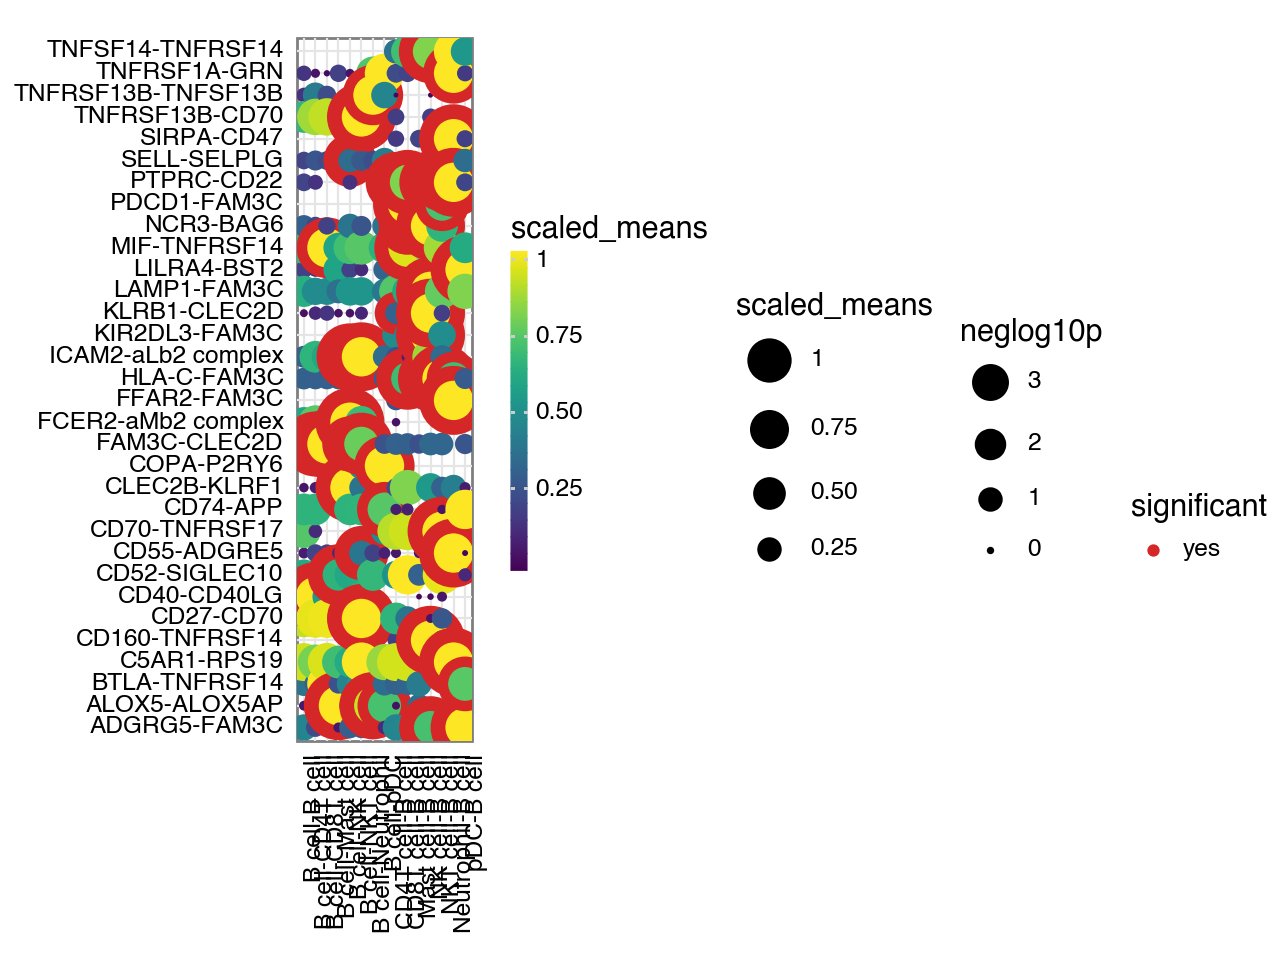

In [8]:
# prepare for non-default style plotting
for i in df.index:
    if df.at[i, colm] == 0:
        df.at[i, colm] = np.nan
df["x_means"] = df[colm]
df["y_means"] = df[colm]
for i in df.index:
    if df.at[i, "pvals"] < alpha:
        df.at[i, "x_means"] = np.nan
        if df.at[i, "pvals"] == 0:
            df.at[i, "pvals"] = 0.001
    if df.at[i, "pvals"] >= alpha:
        if keep_significant_only:
            df.at[i, "y_means"] = np.nan

df["x_stroke"] = df["x_means"]

set_x_stroke(df=df, isnull=False, stroke=0)
set_x_stroke(df=df, isnull=True, stroke=highlight_size)


if exclude_interactions is not None:
    if not isinstance(exclude_interactions, list):
        exclude_interactions = [exclude_interactions]
    df = df[~df.interaction_group.isin(exclude_interactions)]


df["neglog10p"] = abs(-1 * np.log10(df.pvals))
df["neglog10p"] = [0 if x >= 0.05 else j for x, j in zip(df["pvals"], df["neglog10p"])]
df["significant"] = ["yes" if x < alpha else np.nan for x in df.pvals]

if all(pd.isnull(df["significant"])):
    df["significant"] = "no"
    highlight_col = "#FFFFFF"
if return_table:
    print(df)
else:
    # set global figure size
    options.figure_size = figsize
    if highlight_size is not None:
        max_highlight_size = highlight_size
        stroke = df.x_stroke
    else:
        stroke = df.neglog10p



    # plotting
    if default_style:
        g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke)) 
    else:
        if all(df["significant"] == "no"):
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke))
            default_style = True
        else:
            highlight_col = "#FFFFFF"  # enforce this
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour=colm, fill="significant", size=colm, stroke=stroke))
    g = (
        g
        + geom_point(na_rm=True)
        + theme_bw()
        + theme(
            axis_text_x=element_text(angle=90, hjust=0, colour="#000000"),
            axis_text_y=element_text(colour="#000000"),
            axis_ticks=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            legend_key=element_rect(alpha=0, width=0, height=0),
            legend_direction="vertical",
            legend_box="horizontal",
        )
        + scale_size_continuous(range=(0, max_size), aesthetics=["size"])
        + scale_size_continuous(range=(0, max_highlight_size), aesthetics=["stroke"])
    )
    if default_style:
        g = (
            g
            + scale_colour_manual(values=highlight_col, na_translate=False)
            + guides(
                fill=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
            + scale_fill_continuous(cmap_name=cmap_name)
        )
    else:
        g = (
            g
            + scale_fill_manual(values=highlight_col, na_translate=False)
            + guides(
                colour=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
        )
        df2 = df.copy()
        for i in df2.index:
            if df2.at[i, "pvals"] < alpha:
                df2.at[i, colm] = np.nan
        g = (
            g
            + geom_point(aes(x="celltype_group", y="interaction_group", colour=colm, size=colm), df2, inherit_aes=False, na_rm=True)
            + scale_colour_continuous(cmap_name=cmap_name)
        )
    if highlight_size is not None:
        g = g + guides(stroke=None)
    if title != "":
        g = g + ggtitle(title)
    elif gene_family is not None:
        if isinstance(gene_family, list):
            gene_family = ", ".join(gene_family)
        g = g + ggtitle(gene_family)
    print(g)

[0.293249354005168, 0.1787467700258398, 0.01925064599483204, 0.02955426356589148, 0.038727390180878556, 0.009851421188630492, 0.029198966408268735, 0.013824289405684755, 0.035949612403100774, 0.0, 0.0, 0.0, 0.0052325581395348845, 0.0, 0.010109819121447029, 0.010885012919896641, 0.008979328165374677, 0.0, 0.0, 0.011563307493540051, 0.0, 0.016020671834625324, 0.011337209302325582, 0.006201550387596899, 0.022674418604651164, 0.01366279069767442, 0.024644702842377263, 0.0316860465116279, 0.016117571059431526, 0.051388888888888894, 0.9808462532299744, 0.835562015503876, 0.2862693468627577, 0.176642476398433, 0.05031789865776123, 0.055070323036413855, 0.04948301329394387, 0.01332605484554621, 0.02087213409543382, 0.005201978036092737, 0.03384496821013423, 0.0, 0.0, 0.0, 0.014482049964677928, 0.0, 0.007257080470104682, 0.005587309742469976, 0.0015092158499775221, 0.0, 0.0, 0.009601181683899555, 0.0, 0.03050542675486481, 0.01409671825830069, 0.008059854858390598, 0.017307815811444353, 0.028225

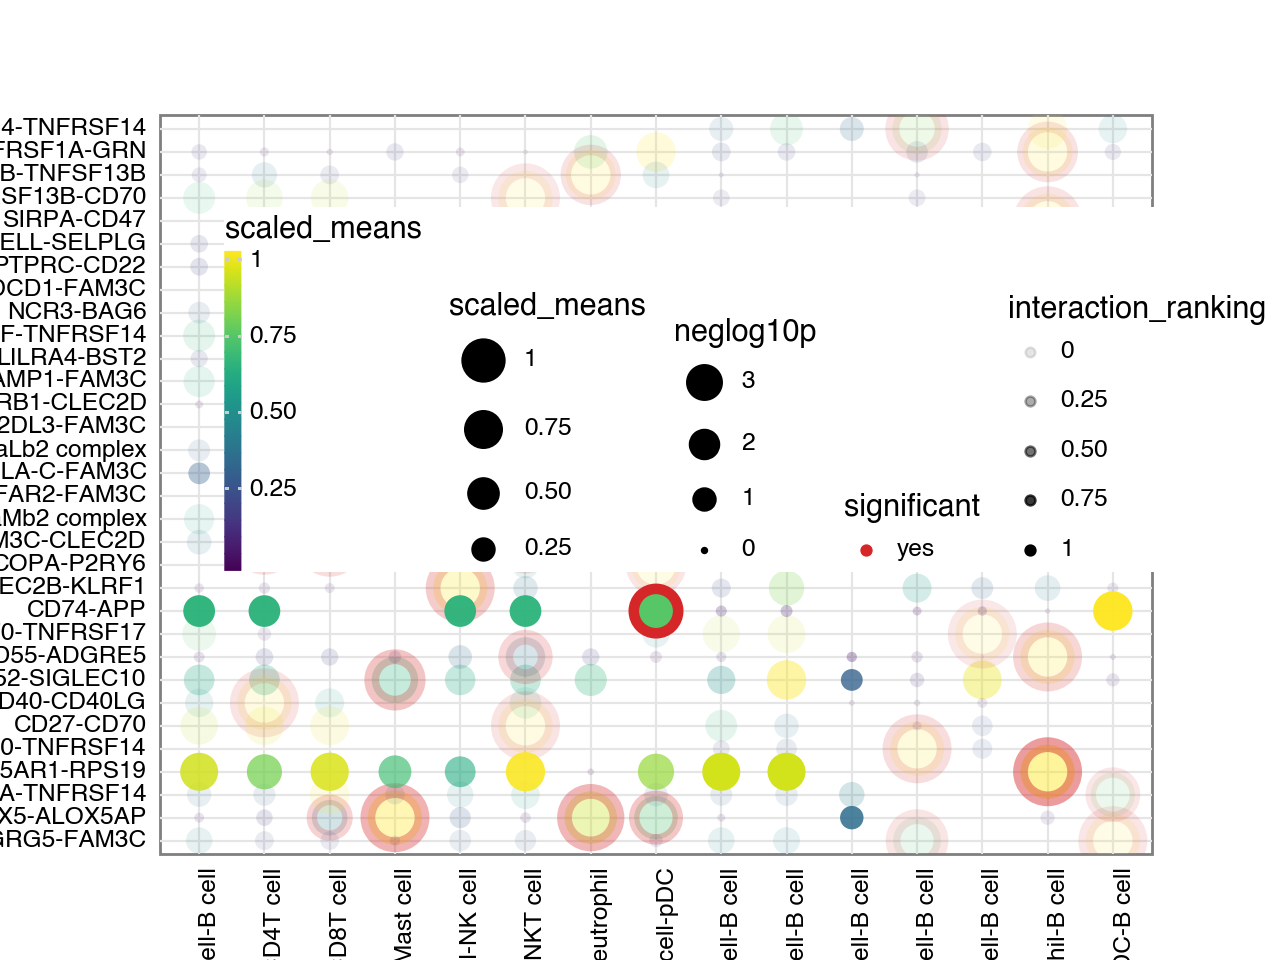

In [9]:
filter_by_interaction_scores = 75
interaction_score_ranking = True

for i in df.index:
    if df.at[i, colm] == 0:
        df.at[i, colm] = np.nan
df["x_means"] = df[colm]
df["y_means"] = df[colm]
transparency_score = []
for i in df.index:
    if df.at[i, "pvals"] < alpha:
        df.at[i, "x_means"] = np.nan
        if df.at[i, "pvals"] == 0:
            df.at[i, "pvals"] = 0.001
    if df.at[i, "pvals"] >= alpha:
        if keep_significant_only:
            df.at[i, "y_means"] = np.nan
    if df.at[i, "interaction_scores"] < 1:
        df.at[i, "x_means"] = np.nan
    transparency_score.append(df.at[i, "interaction_scores"]/100)
print(transparency_score)
df["interaction_ranking"] = transparency_score
df["x_stroke"] = df["x_means"]

set_x_stroke(df=df, isnull=False, stroke=0)
set_x_stroke(df=df, isnull=True, stroke=highlight_size)

if exclude_interactions is not None:
    if not isinstance(exclude_interactions, list):
        exclude_interactions = [exclude_interactions]
    df = df[~df.interaction_group.isin(exclude_interactions)]


df["neglog10p"] = abs(-1 * np.log10(df.pvals))
df["neglog10p"] = [0 if x >= 0.05 else j for x, j in zip(df["pvals"], df["neglog10p"])]
df["significant"] = ["yes" if x < alpha else np.nan for x in df.pvals]


if all(pd.isnull(df["significant"])):
    df["significant"] = "no"
    highlight_col = "#FFFFFF"
if return_table:
    print(df)
else:
    # set global figure size
    options.figure_size = figsize
    
    if highlight_size is not None:
        max_highlight_size = highlight_size
        stroke = df.x_stroke
    else:
        stroke = df.neglog10p

    
    # plotting
    if interaction_score_ranking:
        if default_style:
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke, alpha = "interaction_ranking")) 
        else:
            if all(df["significant"] == "no"):
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke, alpha = "interaction_ranking"))
                default_style = True
            else:
                highlight_col = "#FFFFFF"  # enforce this
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour=colm, fill="significant", size=colm, stroke=stroke, alpha = "interaction_ranking"))

    else:
        # if filter_by_interaction_scores is not None:
        #     df=df[df.interaction_scores >= filter_by_interaction_scores]
        if default_style:
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke)) 
        else:
            if all(df["significant"] == "no"):
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke))
                default_style = True
            else:
                highlight_col = "#FFFFFF"  # enforce this
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour=colm, fill="significant", size=colm, stroke=stroke))
    g = (
        g
        + geom_point(na_rm=True, )
        + theme_bw()
        + theme(
            axis_text_x=element_text(angle=90, hjust=0, colour="#000000"),
            axis_text_y=element_text(colour="#000000"),
            axis_ticks=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            legend_key=element_rect(alpha=0, width=0, height=0),
            legend_direction="vertical",
            legend_box="horizontal",
        )
        + scale_size_continuous(range=(0, max_size), aesthetics=["size"])
        + scale_size_continuous(range=(0, max_highlight_size), aesthetics=["stroke"])
    )
    if default_style:
        g = (
            g
            + scale_colour_manual(values=highlight_col, na_translate=False)
            + guides(
                fill=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
            + scale_fill_continuous(cmap_name=cmap_name)
        )
    else:
        g = (
            g
            + scale_fill_manual(values=highlight_col, na_translate=False)
            + guides(
                colour=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
        )
        df2 = df.copy()
        for i in df2.index:
            if df2.at[i, "pvals"] < alpha:
                df2.at[i, colm] = np.nan
        g = (
            g
            + geom_point(aes(x="celltype_group", y="interaction_group", colour=colm, size=colm), df2, inherit_aes=False, na_rm=True)
            + scale_colour_continuous(cmap_name=cmap_name)
    )
    if highlight_size is not None:
        g = g + guides(stroke=None)
    if title != "":
        g = g + ggtitle(title)
    elif gene_family is not None:
        if isinstance(gene_family, list):
            gene_family = ", ".join(gene_family)
        g = g + ggtitle(gene_family)
    print(g)


In [29]:
filter_by_interaction_scores = 50
interaction_score_ranking = False

for i in df.index:
    if df.at[i, colm] == 0:
        df.at[i, colm] = np.nan
df["x_means"] = df[colm]
df["y_means"] = df[colm]
transparency_score = []
for i in df.index:
    if df.at[i, "pvals"] < alpha:
        df.at[i, "x_means"] = np.nan
        if df.at[i, "pvals"] == 0:
            df.at[i, "pvals"] = 0.001
    if df.at[i, "pvals"] >= alpha:
        if keep_significant_only:
            df.at[i, "y_means"] = np.nan
    if df.at[i, "interaction_scores"] < 1:
        df.at[i, "x_means"] = np.nan
    transparency_score.append(df.at[i, "interaction_scores"]/100)
print(transparency_score)
df["interaction_ranking"] = transparency_score
df["x_stroke"] = df["x_means"]

set_x_stroke(df=df, isnull=False, stroke=0)
set_x_stroke(df=df, isnull=True, stroke=highlight_size)

if exclude_interactions is not None:
    if not isinstance(exclude_interactions, list):
        exclude_interactions = [exclude_interactions]
    df = df[~df.interaction_group.isin(exclude_interactions)]


df["neglog10p"] = abs(-1 * np.log10(df.pvals))
df["neglog10p"] = [0 if x >= 0.05 else j for x, j in zip(df["pvals"], df["neglog10p"])]
df["significant"] = ["yes" if x < alpha else np.nan for x in df.pvals]


if all(pd.isnull(df["significant"])):
    df["significant"] = "no"
    highlight_col = "#FFFFFF"
if return_table:
    print(df)
else:
    # set global figure size
    options.figure_size = figsize
    
    if highlight_size is not None:
        max_highlight_size = highlight_size
        stroke = df.x_stroke
    else:
        stroke = df.neglog10p

    
    # plotting
    if interaction_score_ranking:
        if default_style:
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke, alpha = "interaction_ranking")) 
        else:
            if all(df["significant"] == "no"):
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke, alpha = "interaction_ranking"))
                default_style = True
            else:
                highlight_col = "#FFFFFF"  # enforce this
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour=colm, fill="significant", size=colm, stroke=stroke, alpha = "interaction_ranking"))

    else:
        if filter_by_interaction_scores is not None:
            check = [df.interaction_scores >= filter_by_interaction_scores]
            if len(check) is not None:
                df=df[df.interaction_scores >= filter_by_interaction_scores]
                df["interaction_scores"] = df[colm]
                print (df)
        if default_style:
            g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke)) 
        else:
            if all(df["significant"] == "no"):
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour="significant", fill=colm, size=colm, stroke=stroke))
                default_style = True
            else:
                highlight_col = "#FFFFFF"  # enforce this
                g = ggplot(df, aes(x="celltype_group", y="interaction_group", colour=colm, fill="significant", size=colm, stroke=stroke))
    g = (
        g
        + geom_point(na_rm=True, )
        + theme_bw()
        + theme(
            axis_text_x=element_text(angle=90, hjust=0, colour="#000000"),
            axis_text_y=element_text(colour="#000000"),
            axis_ticks=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            legend_key=element_rect(alpha=0, width=0, height=0),
            legend_direction="vertical",
            legend_box="horizontal",
        )
        + scale_size_continuous(range=(0, max_size), aesthetics=["size"])
        + scale_size_continuous(range=(0, max_highlight_size), aesthetics=["stroke"])
    )
    if default_style:
        g = (
            g
            + scale_colour_manual(values=highlight_col, na_translate=False)
            + guides(
                fill=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
            + scale_fill_continuous(cmap_name=cmap_name)
        )
    else:
        g = (
            g
            + scale_fill_manual(values=highlight_col, na_translate=False)
            + guides(
                colour=guide_colourbar(barwidth=4, label=True, ticks=True, draw_ulim=True, draw_llim=True, order=1),
                size=guide_legend(
                    reverse=True,
                    order=2,
                ),
                stroke=guide_legend(
                    reverse=True,
                    order=3,
                ),
            )
        )
        df2 = df.copy()
        for i in df2.index:
            if df2.at[i, "pvals"] < alpha:
                df2.at[i, colm] = np.nan
        g = (
            g
            + geom_point(aes(x="celltype_group", y="interaction_group", colour=colm, size=colm), df2, inherit_aes=False, na_rm=True)
            + scale_colour_continuous(cmap_name=cmap_name)
        )
    if highlight_size is not None:
        g = g + guides(stroke=None)
    if title != "":
        g = g + ggtitle(title)
    elif gene_family is not None:
        if isinstance(gene_family, list):
            gene_family = ", ".join(gene_family)
        g = g + ggtitle(gene_family)
    print(g)


[]
Empty DataFrame
Columns: [interaction_group, celltype_group, scaled_means, pvals, interaction_scores, x_means, y_means, x_stroke, neglog10p, significant, interaction_ranking]
Index: []


TypeError: object of type 'NoneType' has no len()

In [ ]:
# # what if df_pvals have different number of rows?
# df_pvals2 = df_pvals.sample(50)
# df_pvals2
# df["pvals2"] = df_pvals2["pvals"]  # with the new indexing strategy, it should work if df_pvals have different columns?
# df
# df[pd.notnull(df["pvals2"])]
# means_matx.melt(ignore_index=False).reset_index()  # need a new index
# print(df)
# df.index = df["index"] + DEFAULT_SEP * 3 + df["variable"]
# df

In [ ]:
# df = means_matx.melt(ignore_index=False).reset_index()  # need a new index for the melted table so it's not just numbers
# df.index = df["index"] + DEFAULT_SEP * 3 + df["variable"]  # like this?
# df.columns = ["interaction_group", "celltype_group", colm]
# df_pvals = pvals_matx.melt(ignore_index=False).reset_index()
# df_pvals = df_pvals["index"] + DEFAULT_SEP * 3 + df_pvals["variable"]  # like this?
# df_pvals.columns = ["interaction_group", "celltype_group", "pvals"]
# df.celltype_group = [re.sub(DEFAULT_SEP, "-", c) for c in df.celltype_group]
# df["pvals"] = df_pvals["pvals"]
# if interaction_scores is not None:
#     df_interaction_scores = interaction_scores_matx.melt(ignore_index=False).reset_index()
#     df_interaction_scores = df_interaction_scores["index"] + DEFAULT_SEP * 3 + df_interaction_scores["variable"]  # like this?
#     df_interaction_scores.columns = ["interaction_group", "celltype_group", colm]
#     df["interaction_scores"] = df_interaction_scores[colm]
# # set factors
# df.celltype_group = df.celltype_group.astype("category")